In [1]:
import re

import pod5
import pysam
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from remora import io, refine_signal_map, util

### Data and Level Table Loading

In [2]:
# data locations
can_pod5_path = "./remora/tests/data/can_reads.pod5"
can_bam_path = "./remora/tests/data/can_mappings.bam"
mod_pod5_path = "./remora/tests/data/mod_reads.pod5"
mod_bam_path = "./remora/tests/data/mod_mappings.bam"

can_pod5_fh = pod5.Reader(can_pod5_path)
can_bam_fh = pysam.AlignmentFile(can_bam_path)
mod_pod5_fh = pod5.Reader(mod_pod5_path)
mod_bam_fh = pysam.AlignmentFile(mod_bam_path)

level_table = "./remora/tests/data/levels.txt"
sig_map_refiner = refine_signal_map.SigMapRefiner(
    kmer_model_filename=level_table,
    scale_iters=0,
    do_fix_guage=True,
)

### Basecall-anchored Metrics

In [3]:
bam_read = next(can_bam_fh)
pod5_read = next(can_pod5_fh.reads(selection=[bam_read.query_name]))
io_read = io.Read.from_pod5_and_alignment(pod5_read, bam_read)
io_read.ref_reg

RefRegion(ctg='chr13', strand='-', start=52303070, end=52309849)

In [4]:
io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=False)

model_levels = sig_map_refiner.extract_levels(util.seq_to_int(io_read.seq))
read_levels = io_read.compute_per_base_metric("dwell_mean", ref_anchored=False)["mean"]
trim_read_levels = io_read.compute_per_base_metric(
    "dwell_trimmean", ref_anchored=False
)["trimmean"]

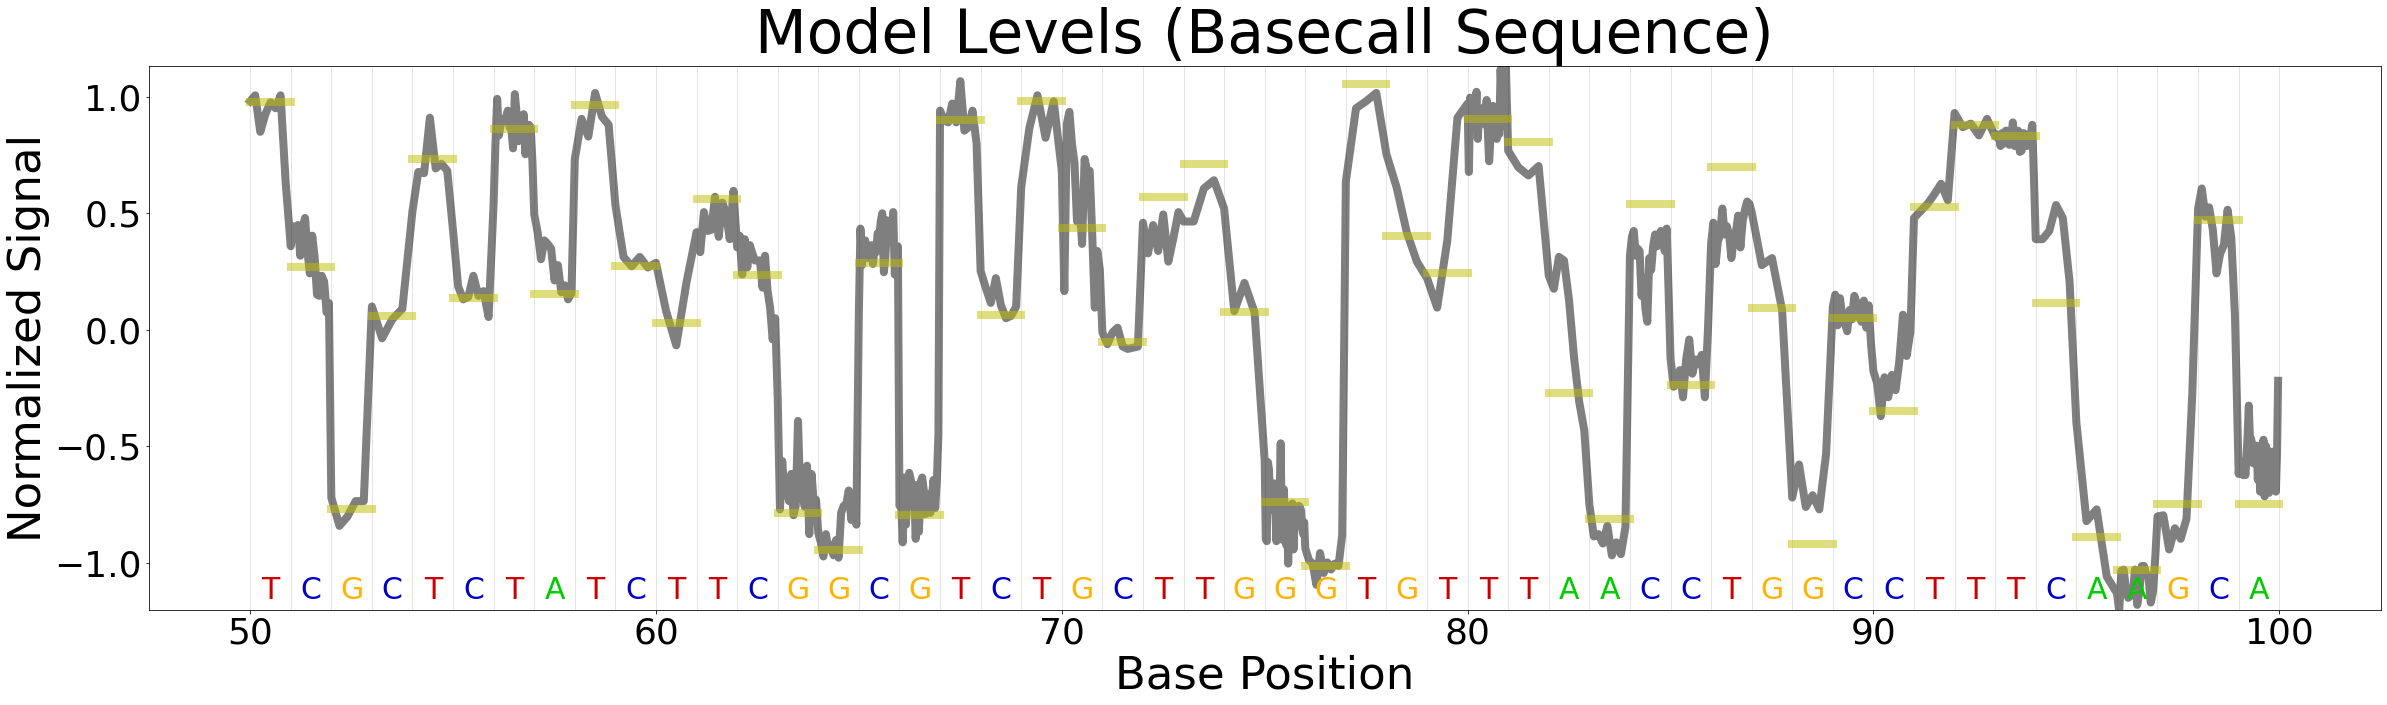

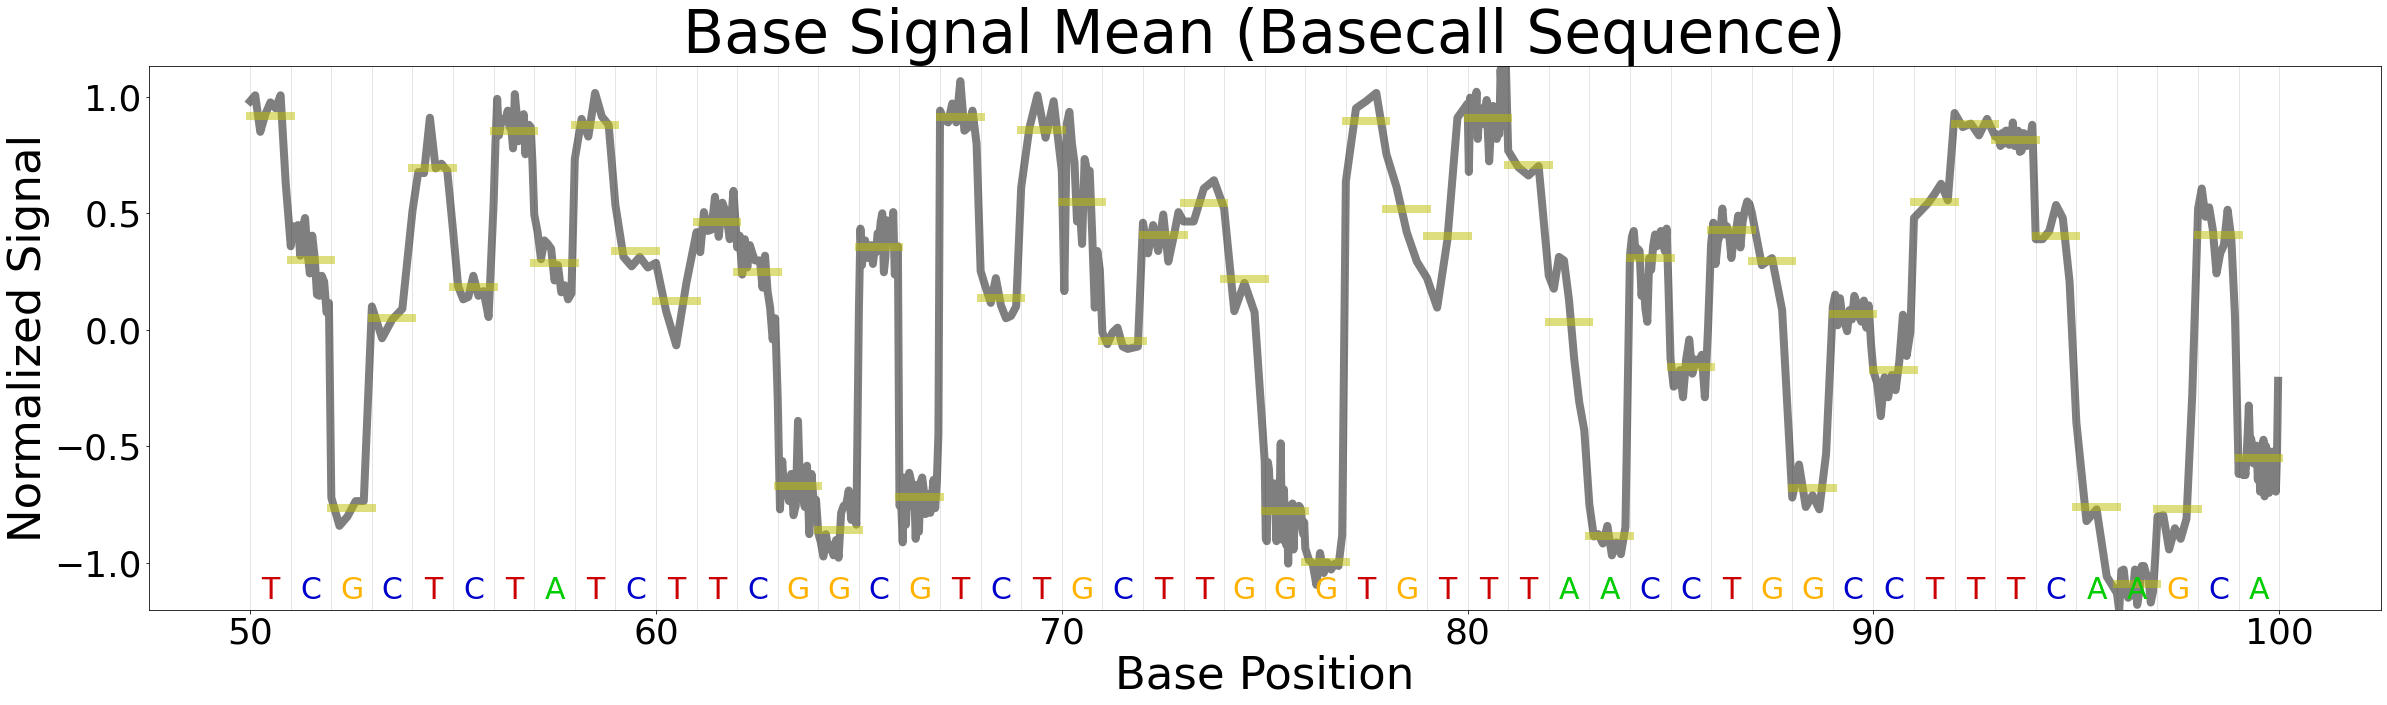

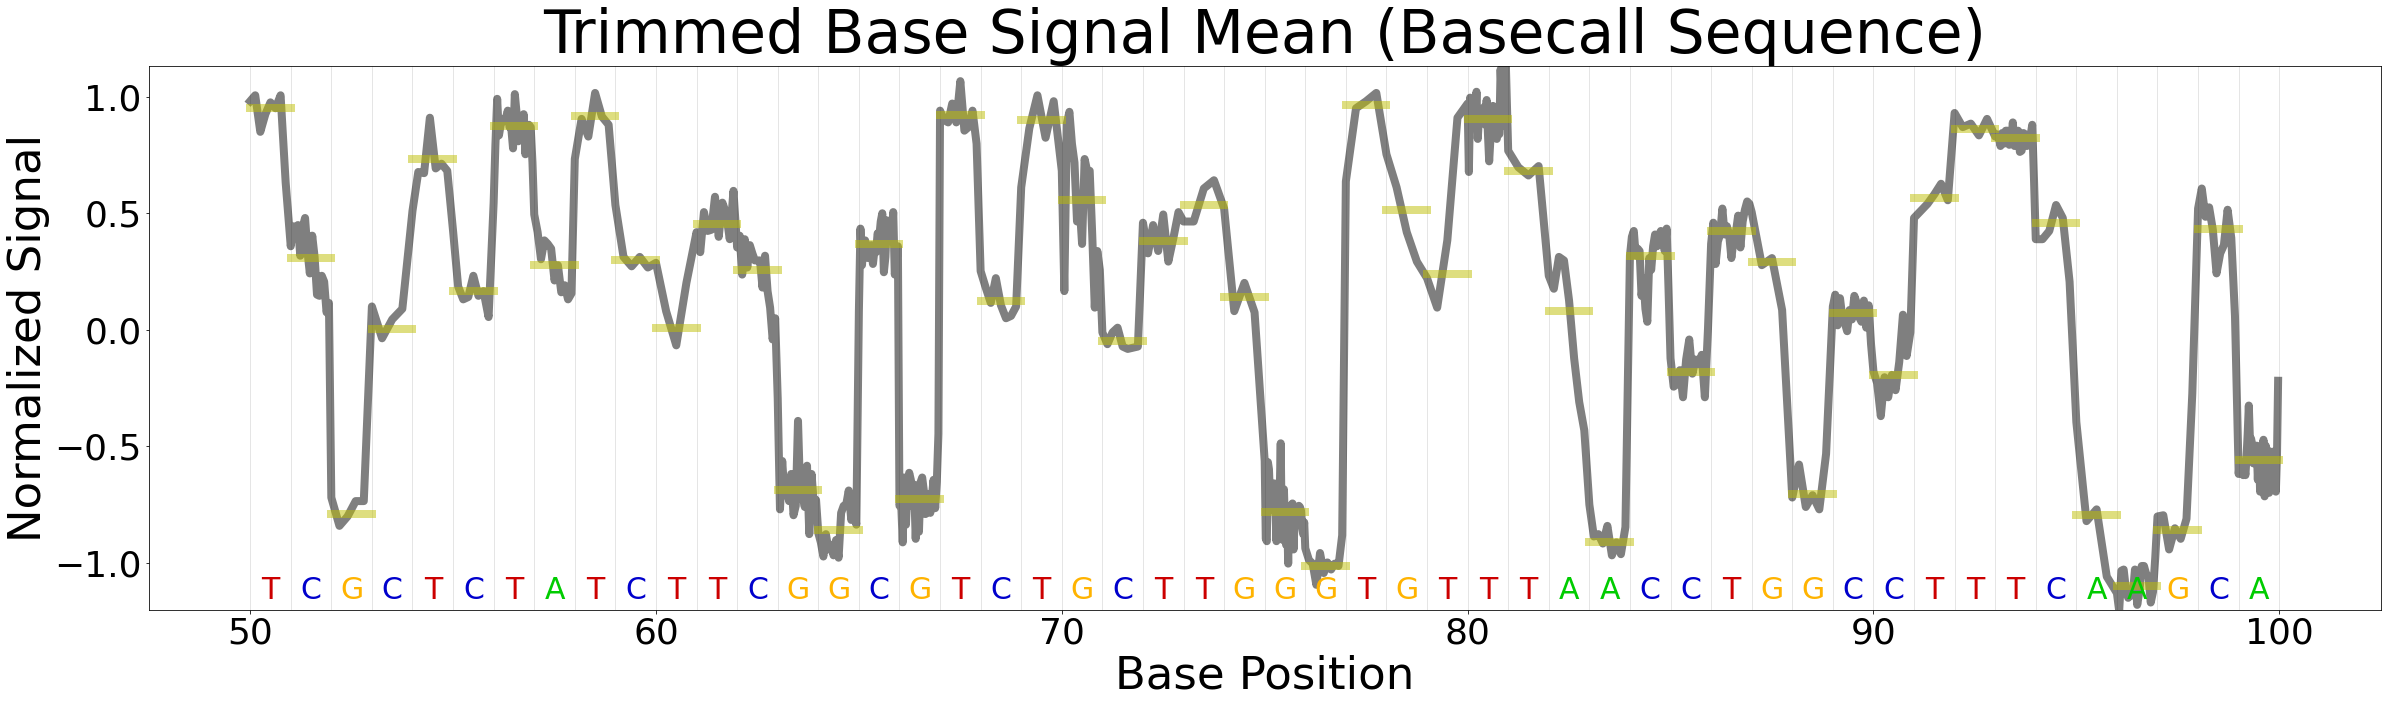

In [5]:
start_base, end_base = 50, 100
read_bc_reg = io_read.extract_basecall_region(start_base, end_base)

fig, ax = read_bc_reg.plot_on_base_coords(levels=model_levels[start_base:end_base])
_ = ax.set_title("Model Levels (Basecall Sequence)", size=60)
fig, ax = read_bc_reg.plot_on_base_coords(levels=read_levels[start_base:end_base])
_ = ax.set_title("Base Signal Mean (Basecall Sequence)", size=60)
fig, ax = read_bc_reg.plot_on_base_coords(levels=trim_read_levels[start_base:end_base])
_ = ax.set_title("Trimmed Base Signal Mean (Basecall Sequence)", size=60)

### Plot Dwell and SD Metrics

In [6]:
read_bc_reg = io_read.extract_basecall_region(start_base, end_base)
read_metrics = io_read.compute_per_base_metric(
    "dwell_trimmean_trimsd", ref_anchored=False
)

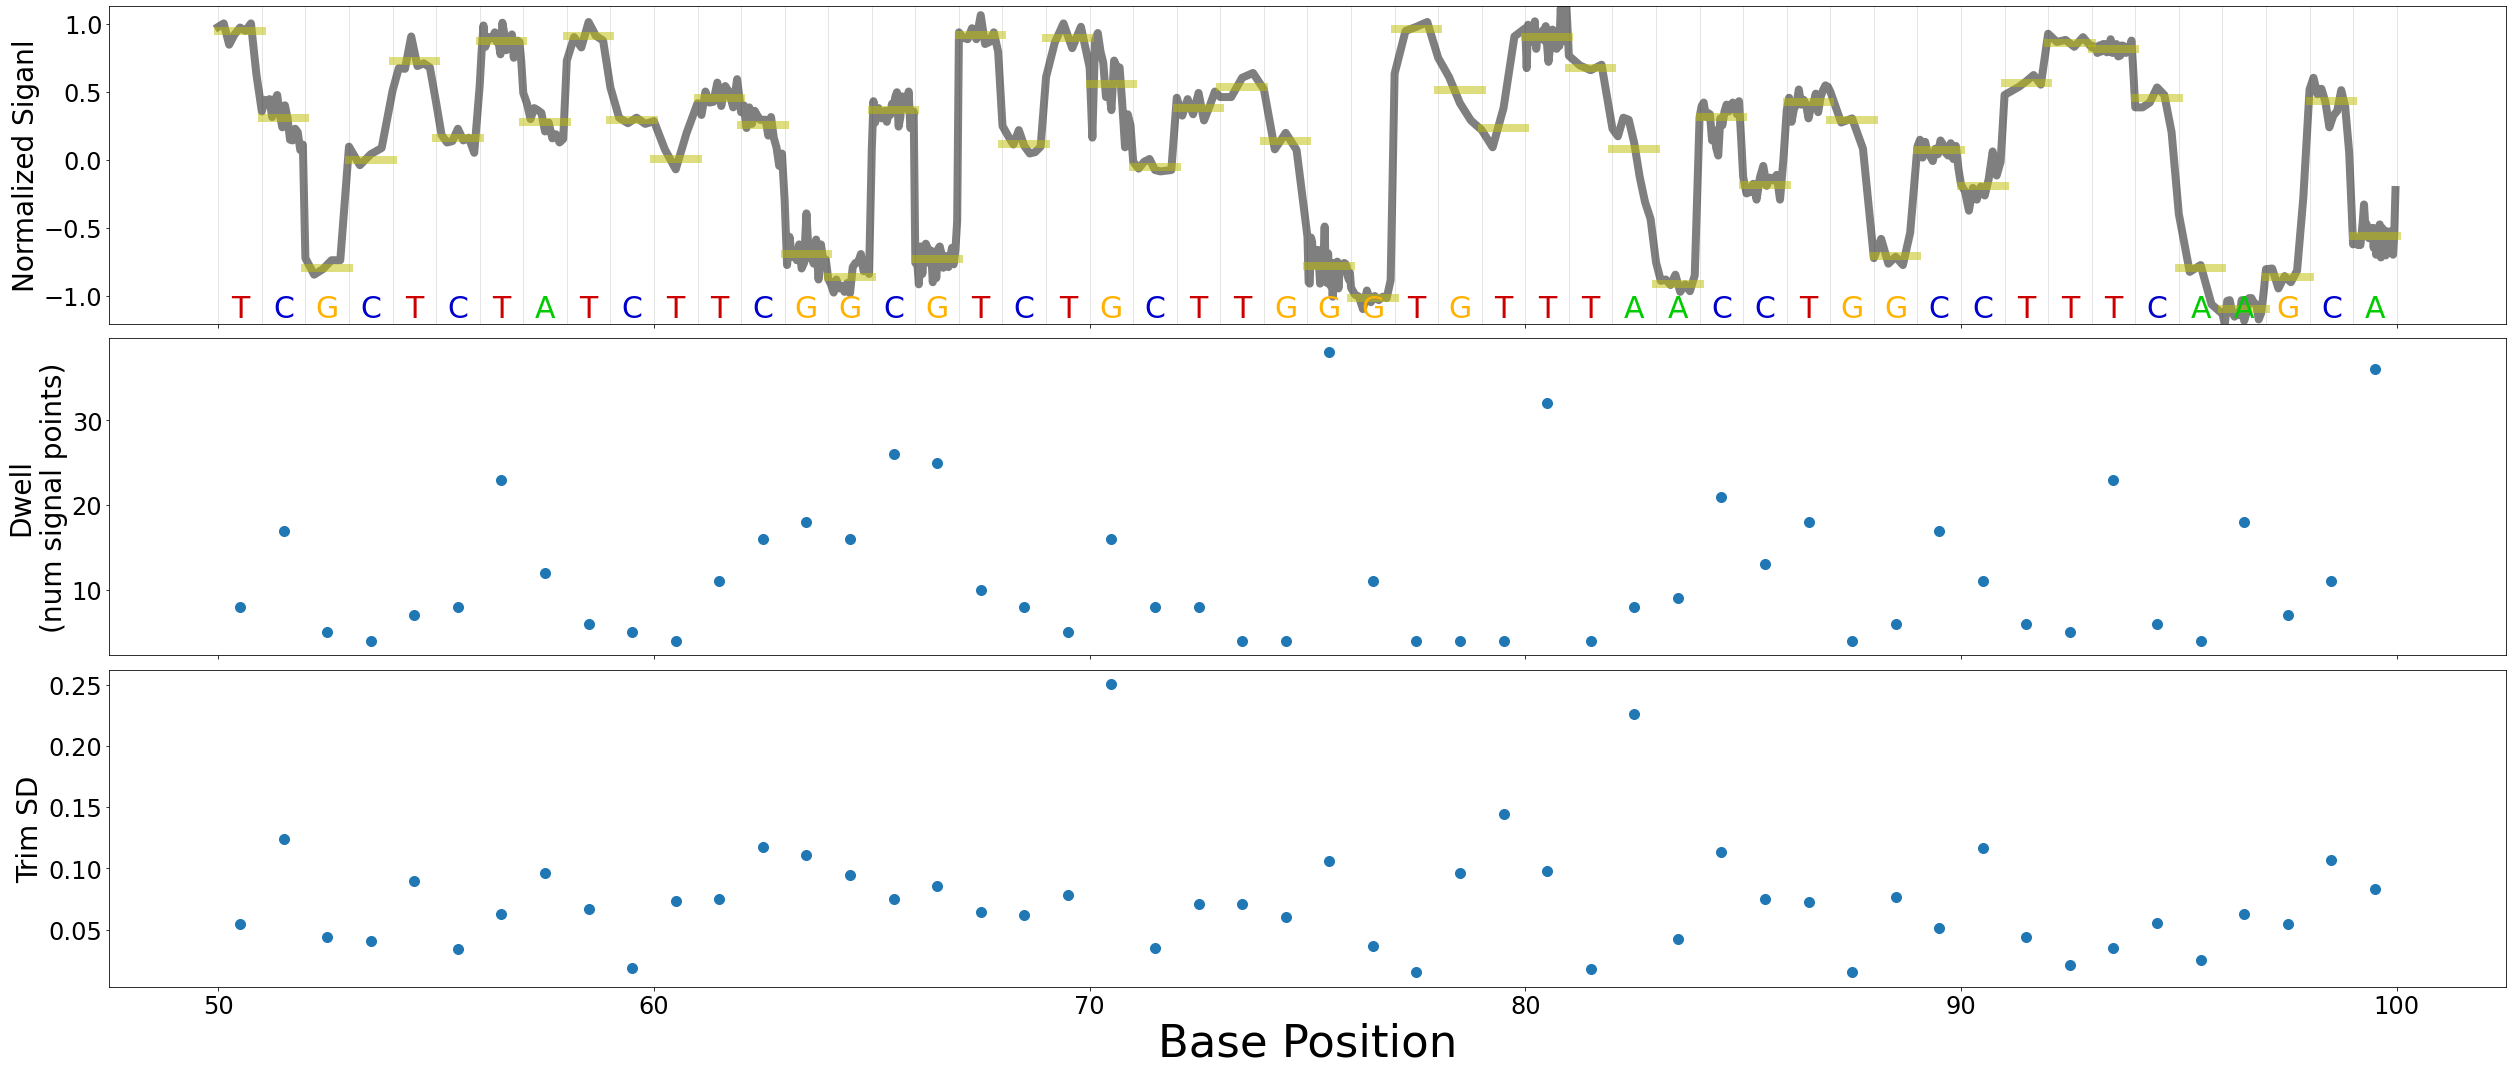

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(
    len(read_metrics), sharex=True, figsize=(35, 5 * len(read_metrics))
)
_ = read_bc_reg.plot_on_base_coords(
    levels=read_metrics["trimmean"][start_base:end_base], fig_ax=(fig, ax1)
)
ax1.set_xlabel("")
ax1.set_ylabel("Normalized Siganl", fontsize=28)
ax1.tick_params(labelsize=24)
_ = ax2.plot(
    np.arange(start_base, end_base) + 0.5,
    read_metrics["dwell"][start_base:end_base],
    ".",
    markersize=20,
)
ax2.set_ylabel("Dwell\n(num signal points)", fontsize=28)
ax2.tick_params(labelsize=24)
_ = ax3.plot(
    np.arange(start_base, end_base) + 0.5,
    read_metrics["trimsd"][start_base:end_base],
    ".",
    markersize=20,
)
ax3.set_ylabel("Trim SD", fontsize=28)
ax3.tick_params(labelsize=24)
_ = ax3.set_xlabel("Base Position", fontsize=45)
plt.tight_layout()

### Reference-anchored Metrics

#### Single Read Plotting

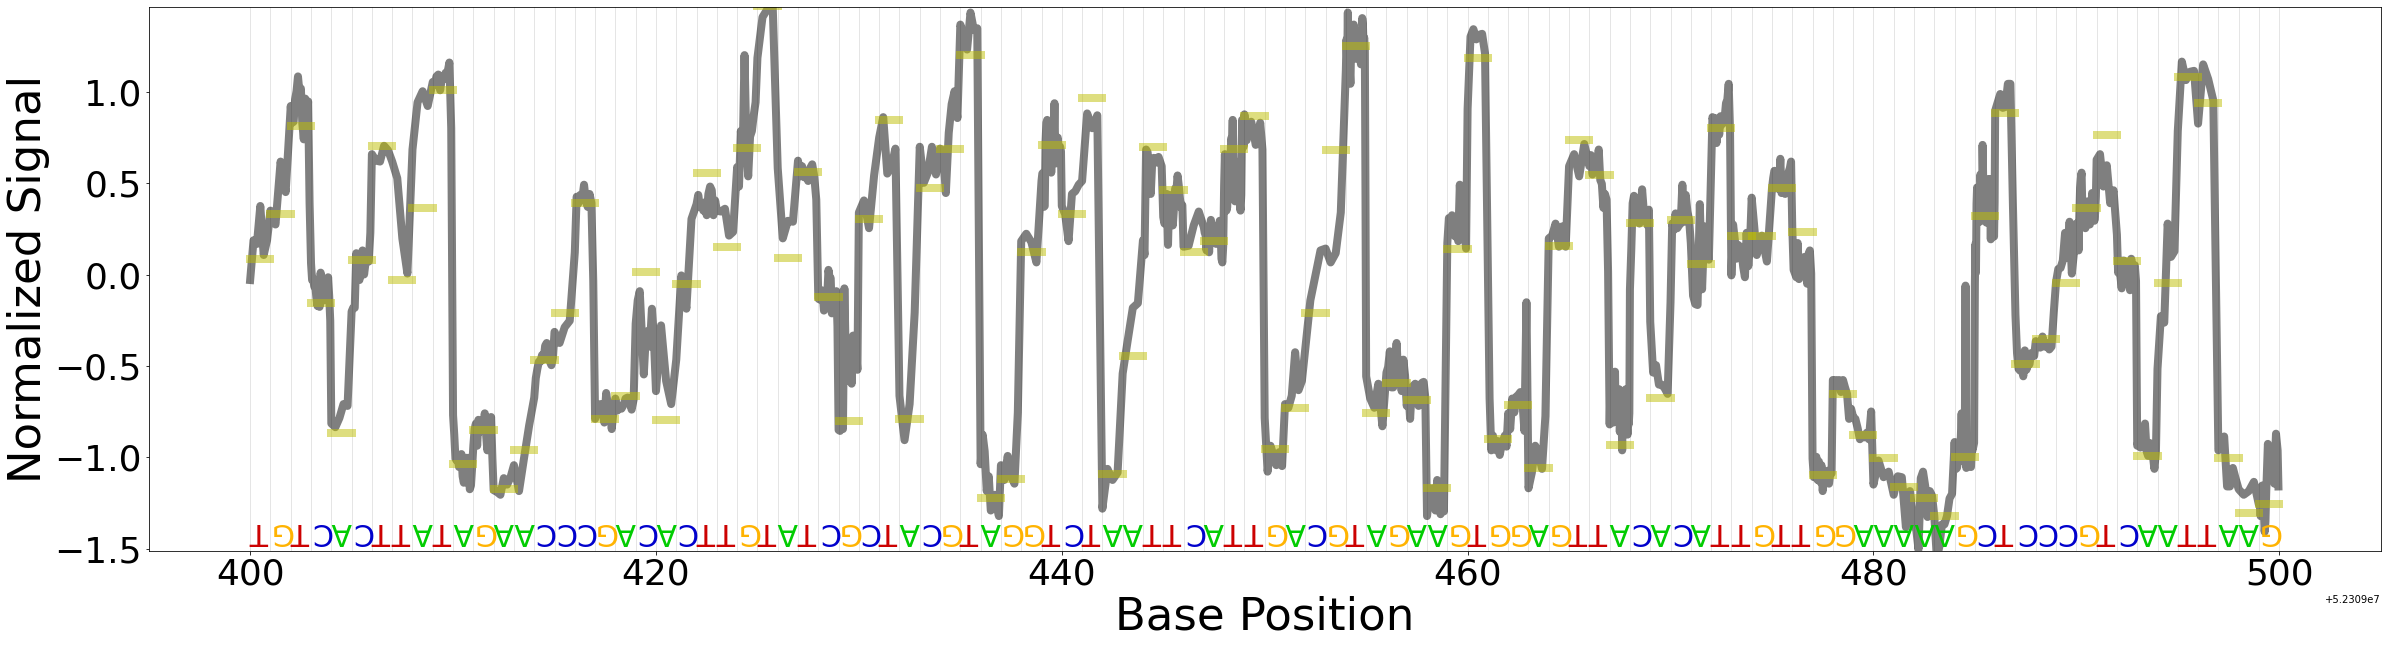

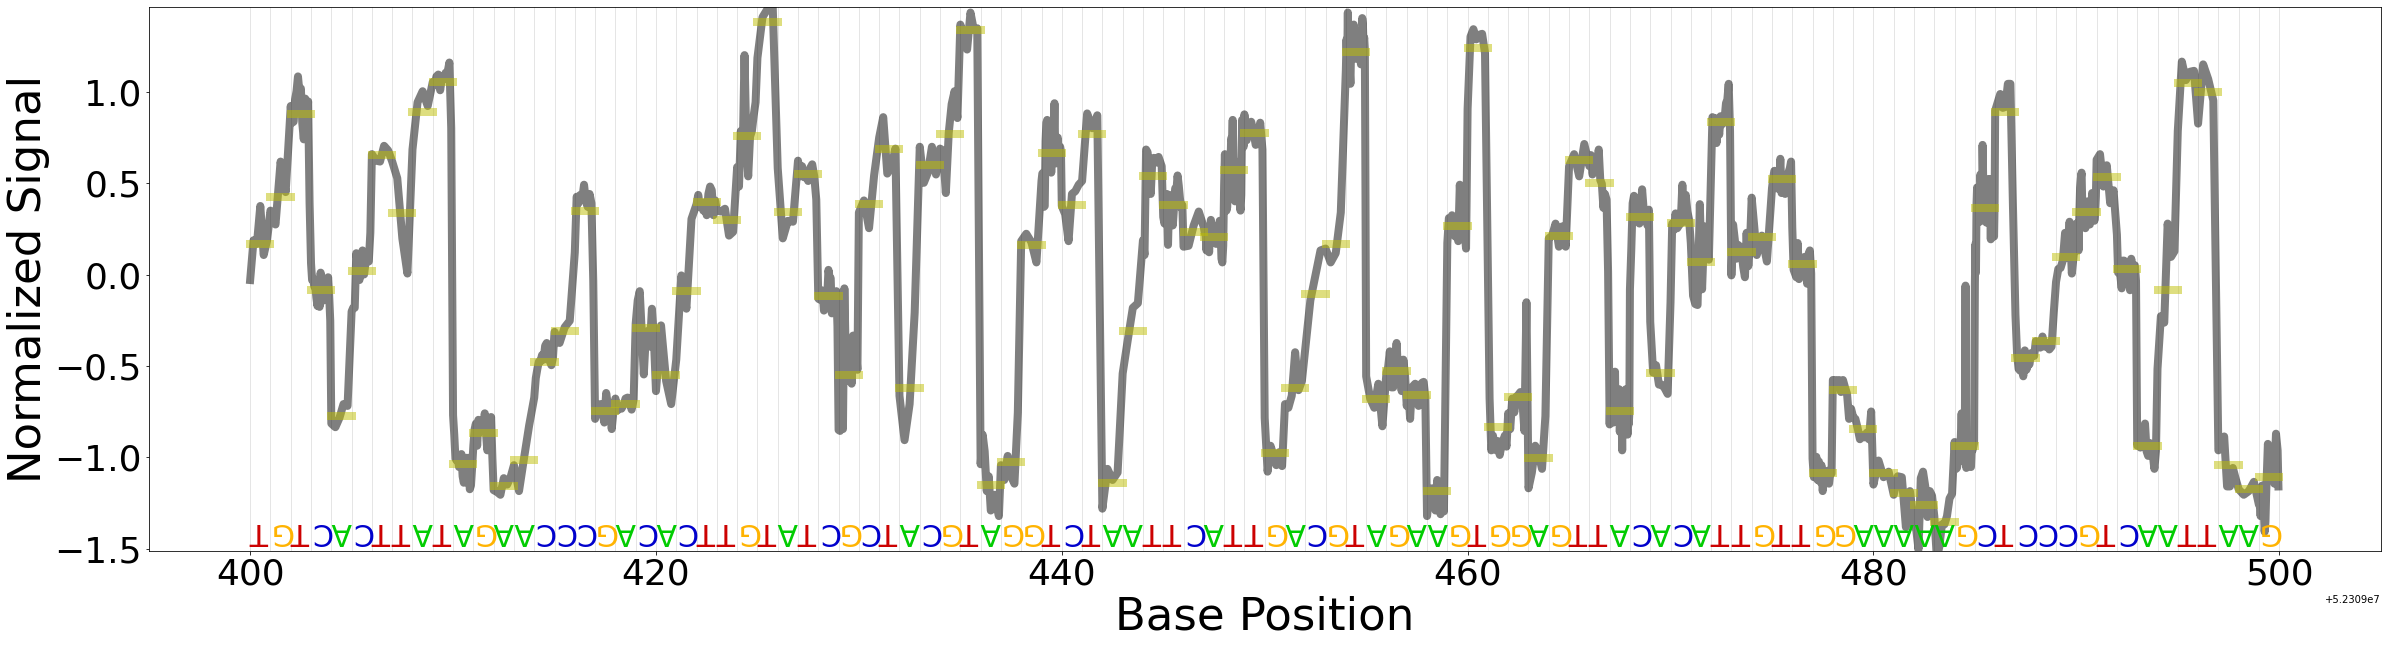

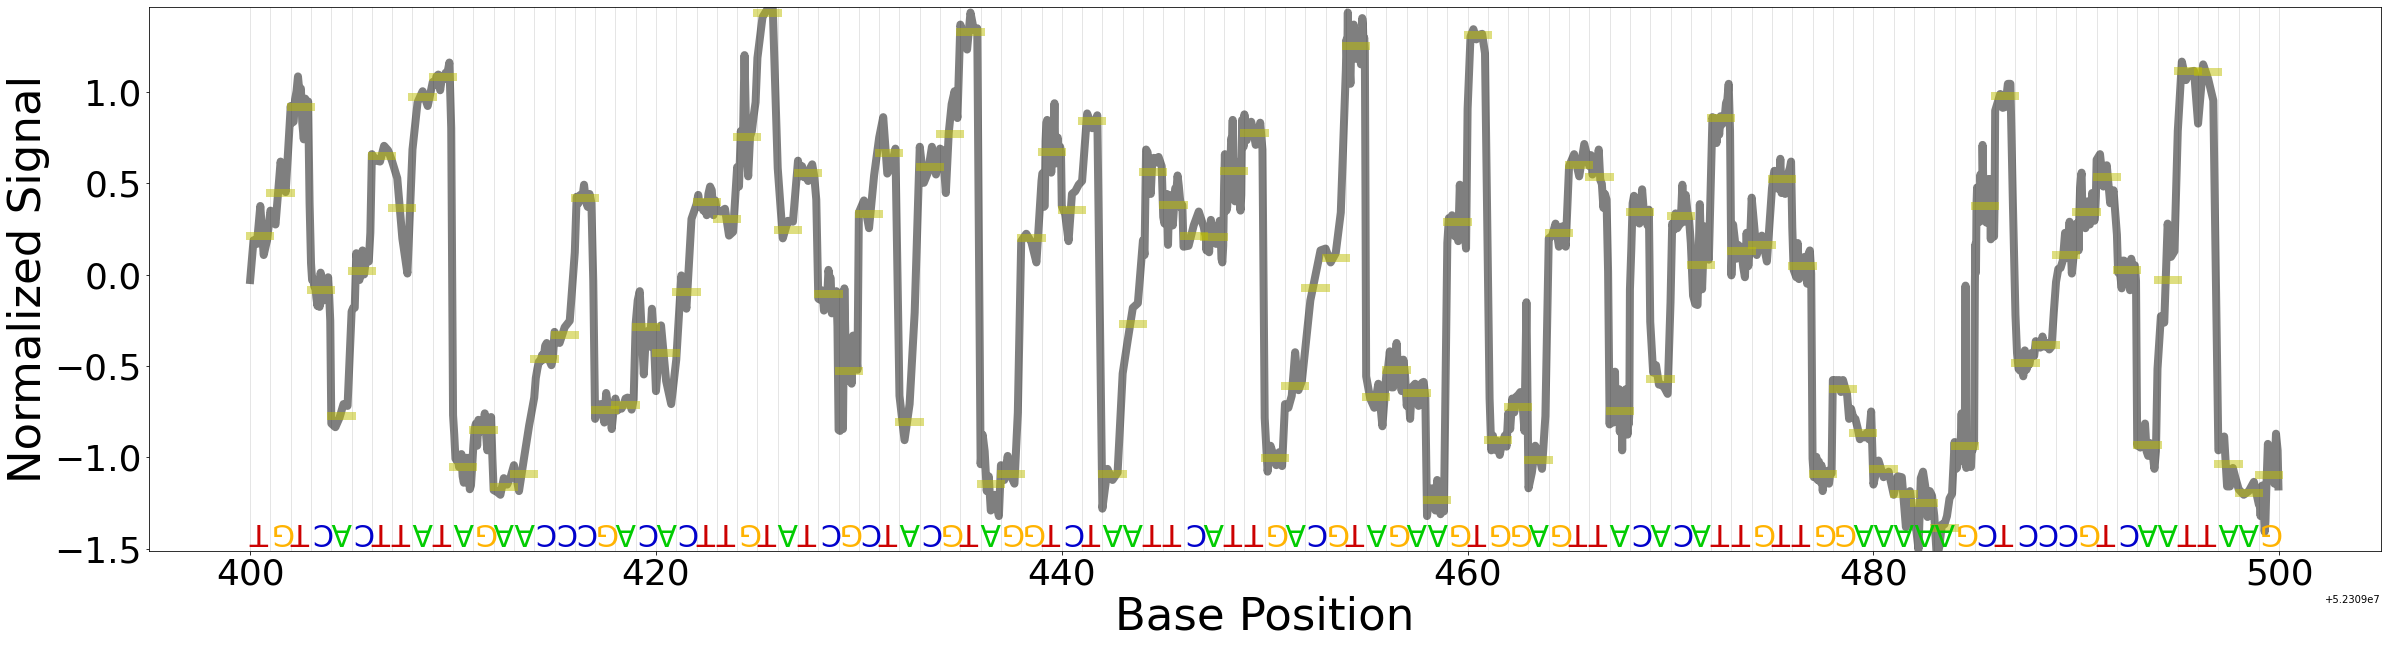

In [8]:
# example read is reverese strand
ref_reg = io.RefRegion(
    ctg=io_read.ref_reg.ctg,
    strand=io_read.ref_reg.strand,
    start=52_309_400,
    end=52_309_500,
)

io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=True)

_, model_levels = io.get_ref_seq_and_levels_from_reads(
    ref_reg, [bam_read], sig_map_refiner, ref_orient=True
)
read_means = io_read.compute_per_base_metric(
    "dwell_mean", ref_anchored=True, region=ref_reg
)["mean"][::-1]
read_trim_means = io_read.compute_per_base_metric(
    "dwell_trimmean", ref_anchored=True, region=ref_reg
)["trimmean"][::-1]

read_ref_reg = io_read.extract_ref_reg(ref_reg)
_ = read_ref_reg.plot_on_base_coords(levels=model_levels)
_ = read_ref_reg.plot_on_base_coords(levels=read_means)
_ = read_ref_reg.plot_on_base_coords(levels=read_trim_means)

### Multiple Reads at Reference Region

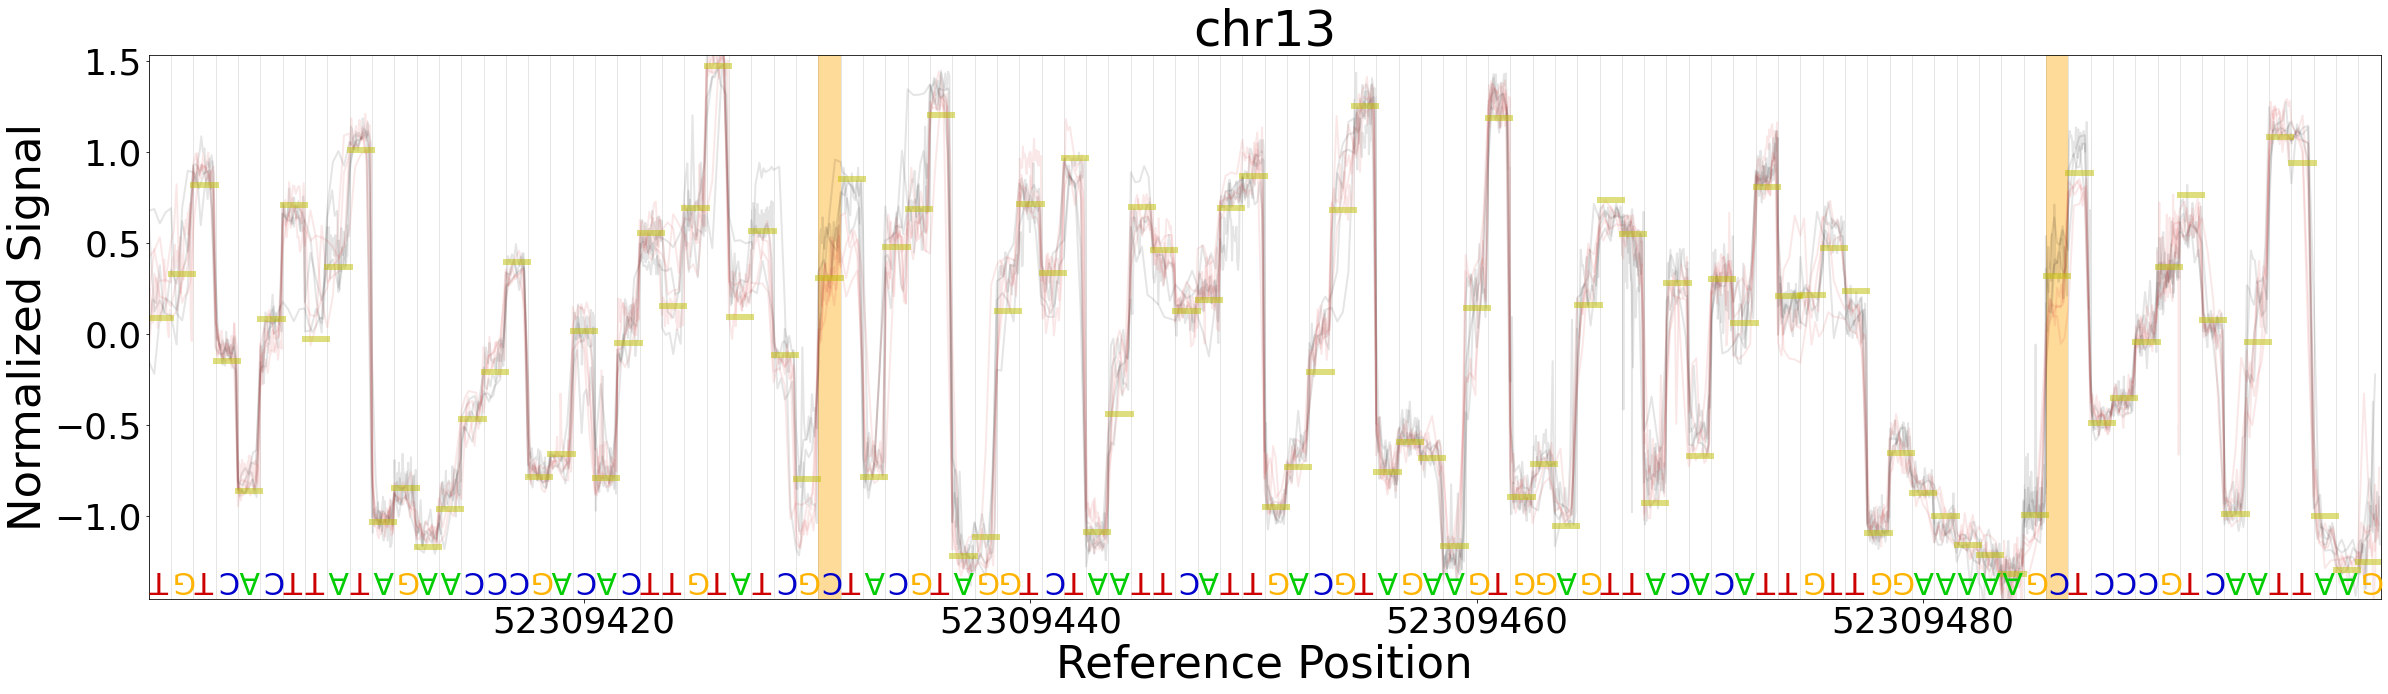

In [9]:
ref_reg = io.RefRegion(ctg="chr13", strand="-", start=52_309_400, end=52_309_500)
ref_seq = io.get_ref_seq_from_reads(ref_reg, io.get_reg_bam_reads(ref_reg, can_bam_fh))
cg_locs = np.array([ref_reg.start + m.start() + 1 for m in re.finditer("GC", ref_seq)])
# cg_locs = np.array([ref_reg.start + m.start() for m in re.finditer("CG", ref_seq)])
# standard signal reference region plot
ax = io.plot_signal_at_ref_region(
    ref_reg,
    [(can_pod5_fh, can_bam_fh), (mod_pod5_fh, mod_bam_fh)],
    sig_map_refiner,
    highlight_ranges=[(loc, loc + 1, "orange") for loc in cg_locs],
)

In [10]:
samples_metrics, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg,
    [(can_pod5_fh, can_bam_fh), (mod_pod5_fh, mod_bam_fh)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner,
    max_reads=1_000,
)
list(samples_metrics[0].keys())

['dwell', 'trimmean', 'trimsd']

In [11]:
# 4 reads, by 100 reference bases
# samples_metrics contains one item for each input sample
# each sample contains a dictionary with metric names pointing to numpy arrays
samples_metrics[0]["trimmean"].shape

(4, 100)

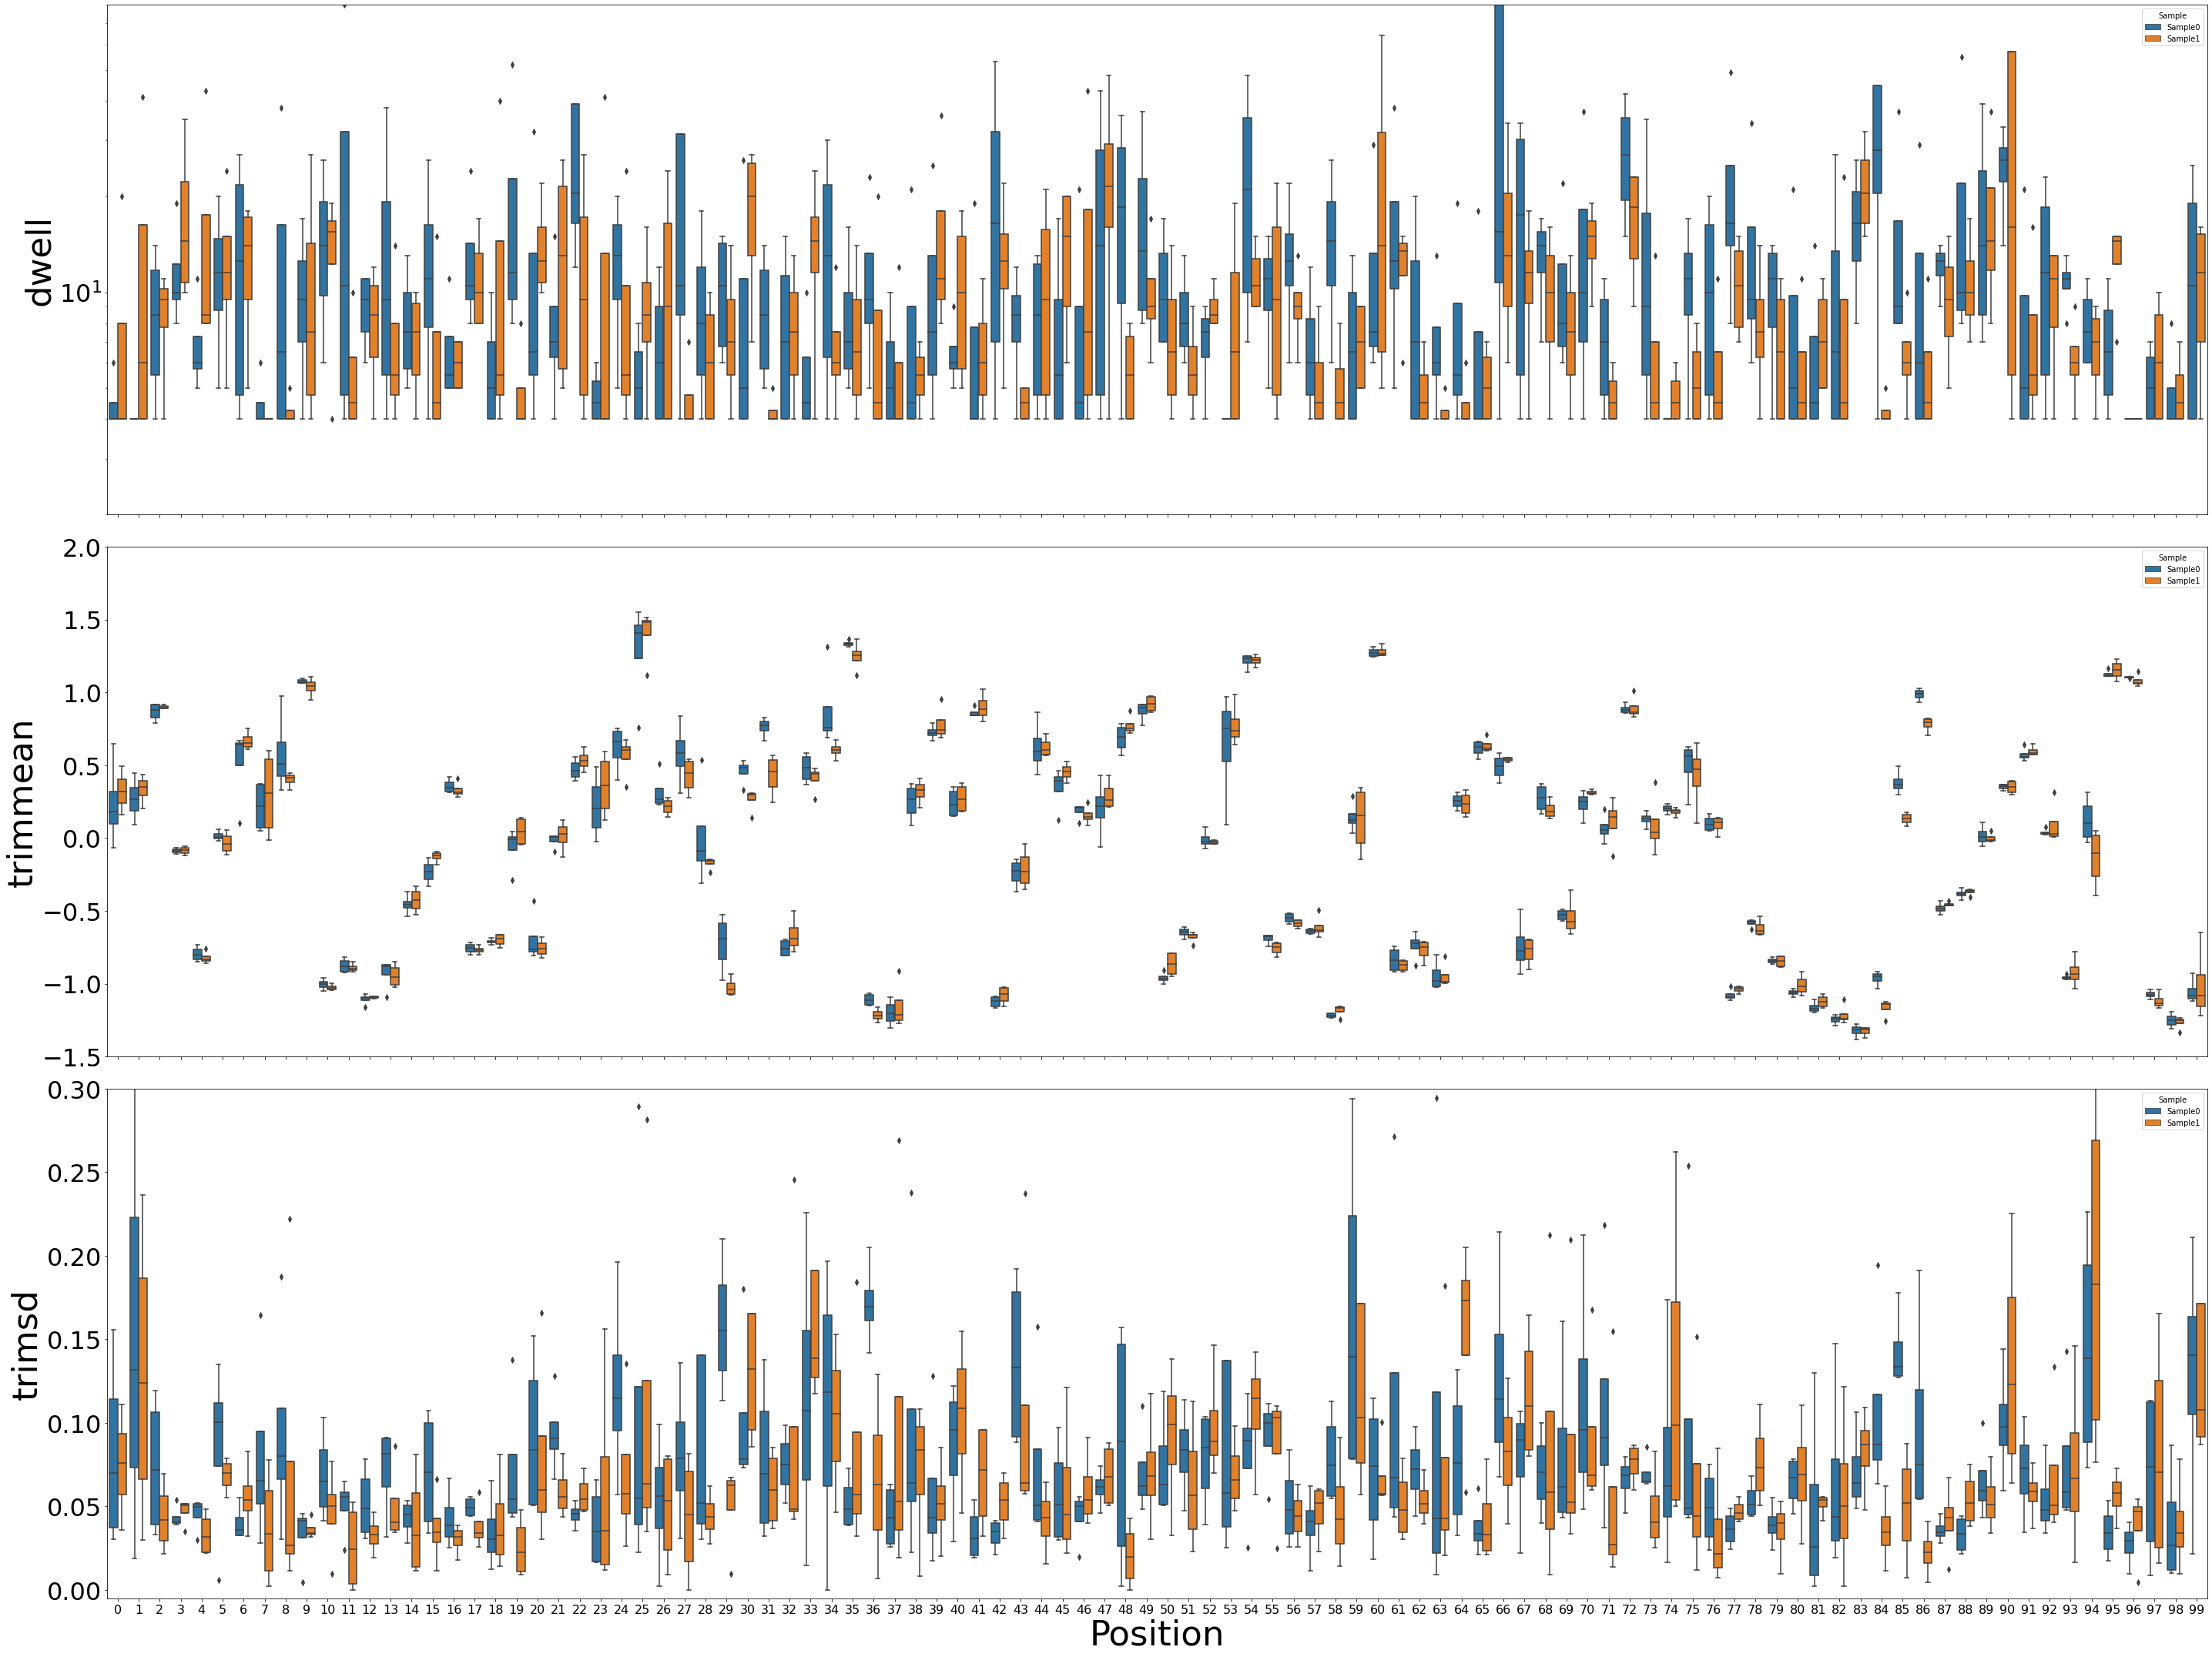

In [12]:
axs = io.plot_metric_at_ref_region(
    ref_reg,
    [(can_pod5_fh, can_bam_fh), (mod_pod5_fh, mod_bam_fh)],
    sig_map_refiner=sig_map_refiner,
    metric="dwell_trimmean_trimsd",
)

### T-test p-values

In [13]:
def nan_ttest(s1, s2):
    return -np.log10(ttest_ind(s1[~np.isnan(s1)], s2[~np.isnan(s2)]).pvalue)

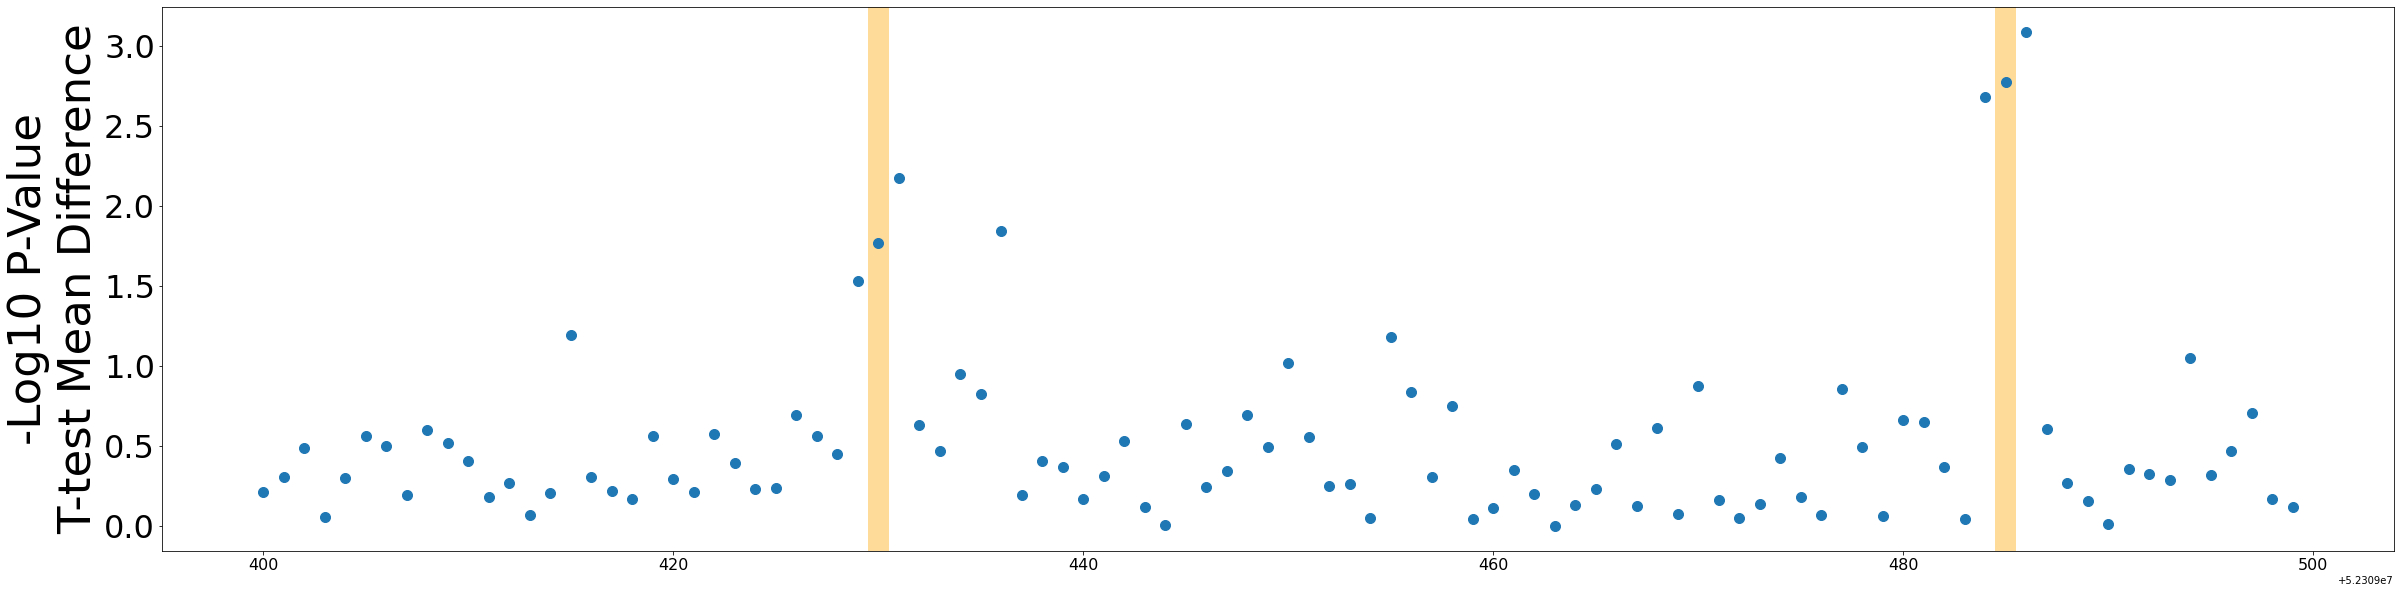

In [14]:
fig, ax = plt.subplots(figsize=(40, 10))

for st in cg_locs:
    ax.axvspan(st - 0.5, st + 0.5, facecolor="orange", alpha=0.4)
_ = ax.plot(
    ref_reg.coord_range,
    [
        nan_ttest(
            samples_metrics[0]["trimmean"][:, idx],
            samples_metrics[1]["trimmean"][:, idx],
        )
        for idx in range(ref_reg.len)
    ],
    ".",
    markersize=20,
)
_ = ax.set_ylabel("-Log10 P-Value\nT-test Mean Difference", fontsize=45)
ax.tick_params(labelsize=16, axis="x")
ax.tick_params(labelsize=32, axis="y")